In [1]:
# supress warnings
import warnings
warnings.filterwarnings('ignore')

import os
import random
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from operator import eq
import pandas as pd
import pandas_ta as ta
import matplotlib
import matplotlib.pyplot as plt
import yfinance as yf

import datetime
from pathlib import Path

## IMPORT SKLEARN
from sklearn import tree
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, plot_confusion_matrix, plot_roc_curve, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, TimeSeriesSplit, cross_val_score, GridSearchCV

from xgboost import XGBClassifier, plot_importance, Booster, plot_tree, to_graphviz, DMatrix

import numpy as np
plt.style.use('seaborn')
from pprint import pprint

In [2]:
# IMPORT TENSORFLOW AND KERAS
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, LSTM
from tensorflow.keras.optimizers import Adam, RMSprop 
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

df = pd.DataFrame()

In [3]:


def set_seeds(seed=2022): 
    random.seed(seed)
    np.random.seed(seed)
    tensorflow.random.set_seed(seed)



In [4]:
equityData = pd.read_excel('StockDataCSV/EquityDataExcel.xlsx', sheet_name='Sheet1', index_col=0, usecols=[0,1], engine='openpyxl')
equityData.dropna(inplace=True)
equityData.drop(index=equityData.index[0], axis=0, inplace=True)
equityData.head()

,Adj Close
2017-07-31 00:00:00,2875.34
2017-08-01 00:00:00,2718.26
2017-08-02 00:00:00,2710.67
2017-08-03 00:00:00,2804.73
2017-08-04 00:00:00,2895.89


In [5]:
### Path to store results

results_path = Path('results', 'lstm_time_series')
if not results_path.exists():
    results_path.mkdir(parents=True)

In [6]:
data = equityData['Adj Close']

data = data.to_numpy()
data = np.reshape(data, (-1, 1))
data.shape

(1826, 1)

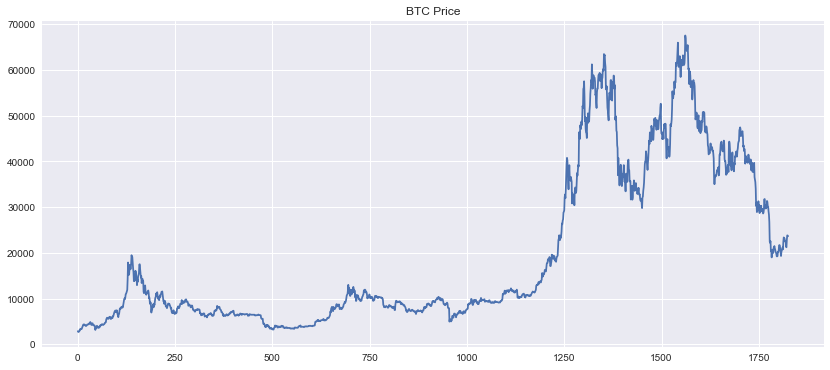

In [7]:
# Visualization 
plt.figure(figsize=(14,6))
plt.title('BTC Price')
plt.plot(data);

In [8]:
#### TRAIN - TEST SPLIT
# Splitting the datasets into training and testing data.
train_data, test_data = train_test_split(data, train_size=0.8, test_size=0.2, shuffle=False)

# Output the train and test data size
print(f"Train and Test Size {len(train_data)}, {len(test_data)}")

Train and Test Size 1460, 366


In [9]:
#### PREPROCESSING
# Scale the features MinMax for training and test datasets
scaler = MinMaxScaler()
scaled_train_data = scaler.fit_transform(train_data)
scaled_test_data = scaler.transform(test_data)

In [10]:
#### GENERATE SEQUENCE

def generate_sequence(data, sequence_length=60):
    
    # create X & y data array
    X = []
    y = []

    for i in range(sequence_length, len(data)):
        X.append(data[i - sequence_length:i, 0])
        y.append(data[i, 0])
    
    # Converting x_train and y_train to Numpy arrays
    return np.array(X), np.array(y)

In [11]:
# sequence length
lookback = 60

In [12]:
X_train, y_train = generate_sequence(data=scaled_train_data, sequence_length=lookback)
print(f'X_train: {X_train.shape}, y_train {y_train.shape}')

X_train: (1400, 60), y_train (1400,)


In [13]:
X_test, y_test = generate_sequence(data=scaled_test_data, sequence_length=lookback)
print(f'X_test: {X_test.shape}, y_test {y_test.shape}')

X_test: (306, 60), y_test (306,)


In [14]:
#### RESHAPE

# reshaping array
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train = y_train[:, np.newaxis] 

# check the array size
print(f'X_train Shape: {X_train.shape}, y_train {y_train.shape}')

X_train Shape: (1400, 60, 1), y_train (1400, 1)


In [15]:
# reshaping test array
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_test = y_test[:, np.newaxis] 

# check the test array size
print(f'X_test Shape: {X_test.shape}, y_test {y_test.shape}')

X_test Shape: (306, 60, 1), y_test (306, 1)


In [16]:
#### CREATE THE MODEL
def create_model(hu=256, lookback=60):

    tensorflow.keras.backend.clear_session()   
    
    # instantiate the model
    model = Sequential()
    model.add(LSTM(units=hu, input_shape=(lookback, 1), activation = 'relu', return_sequences=False, name='LSTM'))
    model.add(Dense(units=1, name='Output'))              # can also specify linear activation function 
    
    # specify optimizer separately (preferred method))
#     opt = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
    opt = Adam(lr=0.001, epsilon=1e-08, decay=0.0)       # adam optimizer seems to perform better for a single lstm
    
    # model compilation
    model.compile(optimizer=opt, loss='mse', metrics=['mae'])
    
    return model

In [17]:
# lstm network
model = create_model(hu=10, lookback=lookback)

In [18]:
# summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM (LSTM)                 (None, 10)                480       
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


In [19]:
#### TRAIN THE MODEL
# Specify callback functions
model_path = (results_path / 'model.h5').as_posix()
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

my_callbacks = [
    EarlyStopping(patience=10, monitor='loss', mode='min', verbose=1, restore_best_weights=True),
    ModelCheckpoint(filepath=model_path, verbose=1, monitor='loss', save_best_only=True),
    TensorBoard(log_dir=logdir, histogram_freq=1)
]

In [20]:
# Model fitting
lstm_training = model.fit(X_train, 
                          y_train, 
                          batch_size=64, 
                          epochs=500, 
                          verbose=1, 
                          callbacks=my_callbacks, 
                          shuffle=False)

Epoch 1/500
21/22 [===========================>..] - ETA: 0s - loss: 0.0468 - mae: 0.1291
Epoch 1: loss improved from inf to 0.05116, saving model to results/lstm_time_series\model.h5
22/22 [==============================] - 7s 85ms/step - loss: 0.0512 - mae: 0.1396
Epoch 2/500
22/22 [==============================] - ETA: 0s - loss: 0.0258 - mae: 0.0876
Epoch 2: loss improved from 0.05116 to 0.02585, saving model to results/lstm_time_series\model.h5
22/22 [==============================] - 1s 34ms/step - loss: 0.0258 - mae: 0.0876
Epoch 3/500
21/22 [===========================>..] - ETA: 0s - loss: 0.0095 - mae: 0.0703
Epoch 3: loss improved from 0.02585 to 0.01029, saving model to results/lstm_time_series\model.h5
22/22 [==============================] - 1s 36ms/step - loss: 0.0103 - mae: 0.0740
Epoch 4/500
20/22 [==========================>...] - ETA: 0s - loss: 0.0062 - mae: 0.0678
Epoch 4: loss did not improve from 0.01029
22/22 [==============================] - 1s 34ms/step - lo

22/22 [==============================] - 1s 39ms/step - loss: 0.0012 - mae: 0.0199
Epoch 32/500
21/22 [===========================>..] - ETA: 0s - loss: 0.0011 - mae: 0.0190    
Epoch 32: loss improved from 0.00116 to 0.00111, saving model to results/lstm_time_series\model.h5
22/22 [==============================] - 1s 35ms/step - loss: 0.0011 - mae: 0.0194
Epoch 33/500
21/22 [===========================>..] - ETA: 0s - loss: 0.0010 - mae: 0.0185    
Epoch 33: loss improved from 0.00111 to 0.00107, saving model to results/lstm_time_series\model.h5
22/22 [==============================] - 1s 34ms/step - loss: 0.0011 - mae: 0.0188
Epoch 34/500
21/22 [===========================>..] - ETA: 0s - loss: 0.0010 - mae: 0.0180    
Epoch 34: loss improved from 0.00107 to 0.00103, saving model to results/lstm_time_series\model.h5
22/22 [==============================] - 1s 40ms/step - loss: 0.0010 - mae: 0.0184
Epoch 35/500
21/22 [===========================>..] - ETA: 0s - loss: 9.8001e-04 - mae

Epoch 61/500
22/22 [==============================] - ETA: 0s - loss: 7.5158e-04 - mae: 0.0164
Epoch 61: loss improved from 0.00076 to 0.00075, saving model to results/lstm_time_series\model.h5
22/22 [==============================] - 1s 35ms/step - loss: 7.5158e-04 - mae: 0.0164
Epoch 62/500
21/22 [===========================>..] - ETA: 0s - loss: 7.0603e-04 - mae: 0.0155
Epoch 62: loss improved from 0.00075 to 0.00075, saving model to results/lstm_time_series\model.h5
22/22 [==============================] - 1s 37ms/step - loss: 7.4781e-04 - mae: 0.0163
Epoch 63/500
22/22 [==============================] - ETA: 0s - loss: 7.4417e-04 - mae: 0.0163
Epoch 63: loss improved from 0.00075 to 0.00074, saving model to results/lstm_time_series\model.h5
22/22 [==============================] - 1s 50ms/step - loss: 7.4417e-04 - mae: 0.0163
Epoch 64/500
22/22 [==============================] - ETA: 0s - loss: 7.3947e-04 - mae: 0.0162
Epoch 64: loss improved from 0.00074 to 0.00074, saving model 

Epoch 92/500
22/22 [==============================] - ETA: 0s - loss: 0.0012 - mae: 0.0195    
Epoch 92: loss did not improve from 0.00069
22/22 [==============================] - 1s 35ms/step - loss: 0.0012 - mae: 0.0195
Epoch 93/500
21/22 [===========================>..] - ETA: 0s - loss: 0.0012 - mae: 0.0172    
Epoch 93: loss did not improve from 0.00069
22/22 [==============================] - 1s 44ms/step - loss: 0.0013 - mae: 0.0179
Epoch 94/500
20/22 [==========================>...] - ETA: 0s - loss: 5.0587e-04 - mae: 0.0139Restoring model weights from the end of the best epoch: 84.

Epoch 94: loss did not improve from 0.00069
22/22 [==============================] - 1s 35ms/step - loss: 8.6497e-04 - mae: 0.0172
Epoch 94: early stopping


In [ ]:
%tensorboard --logdir logs

In [21]:
#### ERROR CALC


# calculate rmse of loss function
train_rmse_scaled = np.sqrt(model.evaluate(X_train, y_train, verbose=0))
test_rmse_scaled = np.sqrt(model.evaluate(X_test, y_test, verbose=0))
print(f'Train RMSE: {train_rmse_scaled[0]:.4f} | Test RMSE: {test_rmse_scaled[0]:.4f}')

Train RMSE: 0.0261 | Test RMSE: 0.0540


In [22]:
# predictions
y_pred = model.predict(X_test)

10/10 [==============================] - 1s 8ms/step


In [23]:
df = pd.DataFrame({
    'actual': scaler.inverse_transform(y_test).flatten(),
    'prediction': scaler.inverse_transform(y_pred).flatten()})

df['spread'] = df['prediction'] - df['actual']
df

,actual,prediction,spread
0,41034.542969,43333.695312,2299.152344
1,41564.363281,42857.285156,1292.921875
2,43790.894531,42579.710938,-1211.183594
3,48116.941406,42662.523438,-5454.417969
4,47711.488281,43353.300781,-4358.187500
...,...,...,...
301,21239.753906,24327.611328,3087.857422
302,22930.548828,24187.353516,1256.804688
303,23843.886719,24363.062500,519.175781
304,23804.632812,24638.714844,834.082031


In [24]:
print(f'R-square: {r2_score(df.actual, df.prediction):0.4}')

R-square: 0.9318


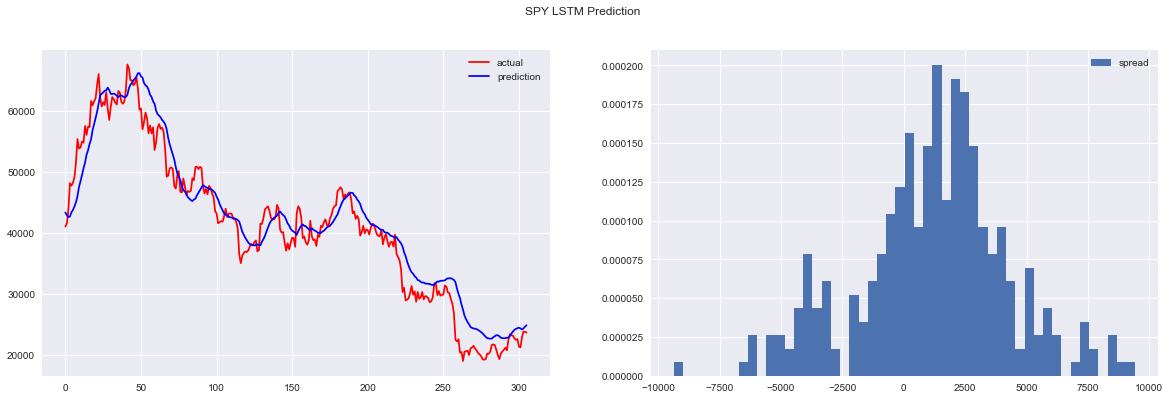

In [25]:
#### PLOT RESULTS
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,6))

ax[0].plot(df.actual, color='red', label='actual')
ax[0].plot(df.prediction, color='blue', label='prediction')
ax[1].hist(df.spread, bins=50, density=True, label='spread')

ax[0].legend()
ax[1].legend()

plt.suptitle('SPY LSTM Prediction');

In [34]:
X_test.shape

(306, 60, 1)

In [35]:
y_test.shape

(306, 1)

In [37]:
y_pred.shape

(306, 1)

In [43]:
le = len(scaled_test_data)

366

In [54]:
#m=[]

#m.append(scaled_test_data[306:366, 0])

#m1 = np.array(m)
#X.append(data[i - sequence_length:i, 0])
#m2 = np.reshape(m1, (m1.shape[0], m1.shape[1], 1))


In [118]:
#p = model.predict(m2)

In [119]:
#scaler.inverse_transform(p).flatten()

In [111]:
std = np.copy(scaled_test_data)
std.shape

(366, 1)

In [112]:
pr = []
pr = np.array(pr)

In [115]:
for i in range (0,60):
    m=[]
    m.append(std[306+i:366+i, 0])
    m1 = np.array(m)
    m2 = np.reshape(m1, (m1.shape[0], m1.shape[1], 1))
    p = model.predict(m2)
    std = np.append(std, p)
    std = np.reshape(std, (-1, 1))
    pr = np.append(pr, scaler.inverse_transform(p).flatten())
    


1/1 [==============================] - 0s 27ms/step


In [116]:
pr

array([25043.85351562, 25476.48046875, 25906.81445312, 26367.65234375,
       26857.11328125, 27373.5546875 , 27904.859375  , 28426.65234375,
       28939.11132812, 29442.17382812, 29935.3671875 , 30418.64257812,
       30892.37890625, 31356.140625  , 31809.86523438, 32253.5078125 ,
       32687.07421875, 33110.640625  , 33524.25      , 33928.0390625 ,
       34322.10546875, 34706.5234375 , 35081.40625   , 35446.93359375,
       35803.2265625 , 36150.46484375, 36488.76953125, 36818.3203125 ,
       37139.23046875, 37451.703125  , 37755.98046875, 38052.140625  ,
       38340.35546875, 38620.83203125, 38893.6171875 , 39158.80078125,
       39416.53515625, 39666.9140625 , 39910.125     , 40146.28515625,
       40375.61328125, 40598.1796875 , 40814.16796875, 41023.58984375,
       41226.69921875, 41423.515625  , 41614.07421875, 41798.44921875,
       41976.8828125 , 42149.3984375 , 42316.13671875, 42477.16015625,
       42632.640625  , 42782.828125  , 42927.59375   , 43067.1875    ,
      

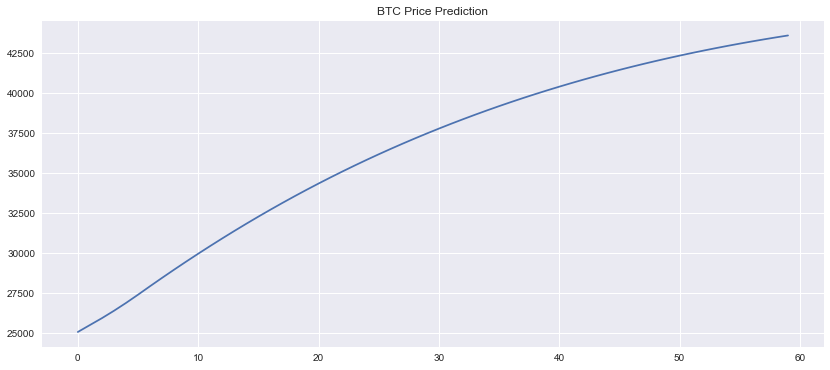

In [117]:
# Visualization 
plt.figure(figsize=(14,6))
plt.title('BTC Price Prediction')
plt.plot(pr);

In [113]:
std.shape

(366, 1)

In [114]:
pr.shape

(0,)